In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/dataframes/final_cleaned.csv').iloc[:,1:]
df.shape

(10070, 2863)

In [28]:
df.loc[(df["status"]==1)&(df['total_raised'] >= 3000000), 'suceeded'] = 1
df.loc[(df["status"]==0)|(df['total_raised'] < 3000000), 'suceeded'] = 0

In [29]:
cat_cols = ['company_name','company_about', 'founded', 'business model','employees','product stage','status','fund_stage','suceeded']
num_cols = ['total_raised','total_rounds', 'investors','ipo_price', 'geo_market_per']
tag_cols = [col for col in df.columns if col.startswith('tag_')]
targetmarket_cols = [col for col in df.columns if col.startswith('targetmarket_')]
sector_list = [col for col in df.columns if col.startswith("sector_")]
target_ind_list = [col for col in df.columns if col.startswith("target_industry_")]
technology_list = [col for col in df.columns if col.startswith("core_technology_")]
bin_cols = tag_cols + targetmarket_cols + sector_list + target_ind_list + technology_list

In [30]:
new_tech_cols = []
new_industry_cols = []
for col in target_ind_list + technology_list:
    if col in technology_list:
        new_tech_cols.append("technology" + col[15:])
    
    elif col in target_ind_list:
        new_industry_cols.append("industry" + col[15:])


d= {}
for i in range(len(new_tech_cols)):
    d[technology_list[i]] =  new_tech_cols[i]

for i in range(len(new_industry_cols)):
    d[target_ind_list[i]] =  new_industry_cols[i]

df.rename(columns=d, inplace=True)


In [31]:
target_ind_list = [col for col in df.columns if col.startswith("industry_")]
technology_list = [col for col in df.columns if col.startswith("technology_")]
bin_cols = tag_cols + targetmarket_cols + sector_list + target_ind_list + technology_list

We deduced the relationship between columns can be seen as a graph,  
Where each column presented as a node.  
The edges are the relationships between specific column to other columns in the company instance.


We used NetworkX module to make the graph and run algorithms on it.  
[NetworkX docs](https://networkx.org/documentation/stable/index.html)

In [7]:
# %pip install networkx seaborn 
import networkx as nx

Note: you may need to restart the kernel to use updated packages.


In [8]:
# e is a list of highly correlated pairs of tags
# We will use pandas corr function to find all correlations which absolute value greater than 0.7

def get_edges(df, v):
    df_cor = df[v].corr()
    e = []

    for i in range(len(df_cor.columns)):
        for j in range(i+1, len(df_cor.columns)):
            if abs(df_cor.iloc[i,j]) > 0.7:
                e.append((df_cor.columns[i], df_cor.columns[j]))
    return e

def make_graph(v, e):
    G = nx.Graph()
    G.add_nodes_from(v)
    G.add_edges_from(e)
    return G



We can use <b>SCC algorithm</b> to find all strongly connected component in the graph, which represents <b>highly correlated columns</b>.  
For the most parts, our columns are structured in a way that theres a <b>certain inclusive tag</b> which can represent the exclusive tags that are highly correlated with.    
Between highly correlated chronic disease tag and celiac or diabetes tag one is more inclusive than the other. Therefore we will remove the exclusive ones.  
In our graph representation:  
$$
\text{an inclusive column} \iff {deg(\text{inclusive column}) > deg(\text{exclusive column})} 
$$ 
For each scc, we can infer and determine that the vertex with the highest degree can represent the other exclusive tags.  

If we will run SCC algorithm, we will get the number of highly correlated 'representitives' that will remain.

In [14]:
#  Runtime ~4.5 minutes

def scc(v, e):
    """
    Calculates the number of connected components in a graph with vertices v and edges e.
    """
    
    # Create a graph with v and e
    G = nx.Graph()
    G.add_nodes_from(v)
    G.add_edges_from(e)
    # Calculate the number of connected components
    return nx.number_connected_components(G)

scc(bin_cols, get_edges(df, bin_cols))


2599

In [9]:
# function to return the max degree of a graph

def get_max_degree(G):
    max_degree = 0
    v = ''
    for vertex in G.nodes():
        if G.degree(vertex) > max_degree:
            max_degree = G.degree(vertex)
            v = vertex
    # print(max_degree)
    return v, max_degree
    
# function to remove all exclusive vertices
# Each iteration we find the vertex with max degree and remove all the adjacent vertices

def get_new_g(v,e):
    G = make_graph(v,e)

    v_name, max_degree = get_max_degree(G)
    removed = 0

    G2 = G.copy()
    while max_degree > 0:

        for adj in G.adj[v_name]:
            G2.remove_node(adj)
            removed += 1
            
        G = G2.copy()
        v_name, max_degree = get_max_degree(G)

    print(f"Total vertices removed: {removed}\n\n")
    return G

We will create the graph of the binary columns and run our algorithm on it.  
After the algorithm is done, the returned graph will include only the not correlated columns.  
We will use the returned nodes to reduce the correlated columns in the dataframe.


In [32]:
# Runtime ~4.5 minutes

new_G = get_new_g(bin_cols,get_edges(df, bin_cols))

Total vertices removed: 247




In [33]:
new_cols = list(new_G.nodes())
len(bin_cols)- len(new_cols)

247

We see the total number of dropped columns are 247.  
We will create the new dataframe:

In [34]:
reduced_cols_df = df[cat_cols + num_cols + new_cols]
print(f'New dataframe shape: {reduced_cols_df.shape}')

New dataframe shape: (10070, 2617)


In our mostly binary dataset case, the outlier columns can be detected by the <b>sum of the 1 values in the column</b> - the column sum.  
After getting the sum of the column, we will use the following function on the values:  
$$
\text{normalized value} = \frac{\text{number of 'succesful' companies with the tag}}{\text{total companies with the tag}}
$$
We will then create a secondary dataset with the columns and their value.  
And check both <b>Z score</b> and <b>IQR</b> methods on the secondary dataset to detect the outliers columns.


We will start by calculating the sum and normalize them:

In [35]:
sum_dict = {}
for col in new_cols:
    sum_dict.update({col: reduced_cols_df[col].sum()})


In [36]:
#  Runtime ~10 minutes
# %pip install tqdm
import tqdm.notebook as tqdm

temp_df = reduced_cols_df[reduced_cols_df['suceeded'] == 1]

normalized = {}

with tqdm.tqdm(total=len(temp_df.columns)) as pbar:
    for col in new_cols:
        counter = 0
        
        for row in temp_df[col]:
            if row == 1:
                counter += 1
        pbar.update(1)
        normalized[col] = counter / sum_dict[col]


    

  0%|          | 0/2617 [00:00<?, ?it/s]

Lets plot the normalized values of the columns:

<AxesSubplot:ylabel='Density'>

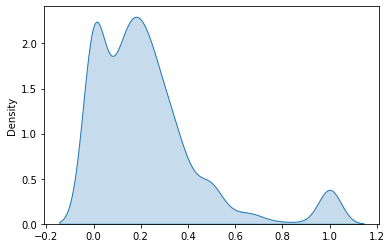

In [52]:
import matplotlib.pyplot as plt


plt.hist(normalized.values(), bins=100)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

# import seaborn as sns
# sns.kdeplot(normalized.values(), shade=True)


We see high rates of 1 and 0 in the normalized values.  
This means that those columns are not helpful for our analysis, either the sum was 0 or a small amount of companies had the tag and succeeded - we will drop them.  
In addition, we can see a Gaussian bell distribution between values ~ 0 < X < 0.4  

Lets try to explore our data first:


In [38]:
norm_df = pd.DataFrame(normalized.values(), index=normalized.keys(), columns = ['Normalized'])
norm_df.describe()

,Normalized
count,2603.000000
mean,0.224544
std,0.232186
min,0.000000
25%,0.054184
50%,0.181818
75%,0.302678
max,1.000000


We see that the mean of the normalized values is 0.2, and the standard deviation is 0.22 - as we observed from the Gaussian distribution.  
We will now remove the columns with normalized 1 and 0 manualy to avoid biased mean and std values for a better outlier detection.

In [39]:
new_normalized = {}
for col, val in normalized.items():
    if val != 0 and val != 1 :
        new_normalized[col] = val
        
print(f'normalized: {len(normalized)}')
print(f'new_normalized: {len(new_normalized)}\n')

new_norm_ser = pd.DataFrame(new_normalized.values(), index=new_normalized.keys(), columns = ['Normalized'])
new_norm_ser.describe()       

normalized: 2603
new_normalized: 1885



,Normalized
count,1885.000000
mean,0.247474
std,0.142161
min,0.017241
25%,0.142857
50%,0.216667
75%,0.330097
max,0.928571


After removing 1 and 0 values, we remain with 1838 columns.  
Lets normalize and plot to see the bell better:

In [40]:
total = new_norm_ser['Normalized'].sum()
new_norm_ser['Normalized'] = new_norm_ser['Normalized'] / total
new_norm_ser

,Normalized
tag_computer-vision,0.000708
tag_behavior-analytics,0.000501
tag_machine-learning,0.000674
tag_consumer-packaged-goods,0.001876
tag_natural-language-processing,0.000736
...,...
technology_Data Storage_Flash,0.001225
technology_Sensing_SWIR,0.000536
technology_Materials & Substances_Adhesive,0.000195
technology_Materials & Substances_Insulation,0.000429


Text(0, 0.5, 'Frequency')

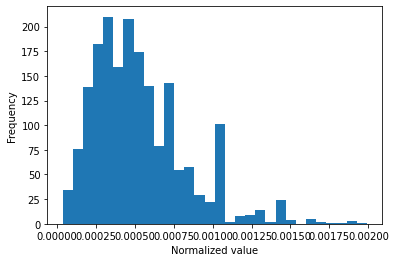

In [41]:
plt.hist(new_norm_ser['Normalized'], bins=30)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

### It means we can start to detect the outliers:

In [42]:
def outlier_detection_zscore(df_orig) -> pd.Series:
    
    df = df_orig.copy()
    z_score = (df['Normalized'] - df['Normalized'].mean()) / df['Normalized'].std()
    outliers = abs(z_score) > 3

    return outliers

z_score_outliers = outlier_detection_zscore(new_norm_ser)
z_score_df = new_norm_ser[z_score_outliers == False]

print(z_score_outliers.value_counts())
print(f"Z Score detected {z_score_outliers.shape[0] - z_score_df.shape[0]} outliers")


False    1867
True       18
Name: Normalized, dtype: int64
Z Score detected 18 outliers


Text(0, 0.5, 'Frequency')

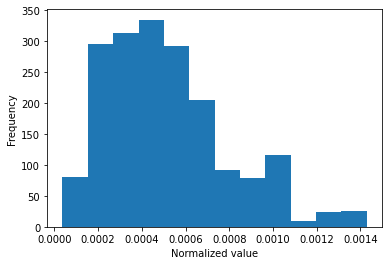

In [43]:
plt.hist(z_score_df['Normalized'], bins=12)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

In [44]:
df_after_cols_reduction = reduced_cols_df.copy()
print(f'Before: {df_after_cols_reduction.shape}')

not_outliers_bin_cols = list(z_score_df.index)
df_after_cols_reduction = df_after_cols_reduction[cat_cols + num_cols + not_outliers_bin_cols]
print(f'After: {df_after_cols_reduction.shape}')

Before: (10070, 2617)
After: (10070, 1881)


We see that after <b>Z Score</b> detection method, we removed 33 columns.  
And total number of columns is 1838 - 33 = 1805.  

Now, we will try to use IQR method, and see the differences:  

In [45]:
iqr_norm = new_norm_ser.copy()
    
Q1 = np.percentile(iqr_norm['Normalized'], 25)
Q3 = np.percentile(iqr_norm['Normalized'], 75)
IQR = 1.5*(Q3 - Q1)

lower_bound = Q1 - IQR
upper_bound = Q3 + IQR

iqr_norm.loc[(iqr_norm["Normalized"]> upper_bound) | (iqr_norm["Normalized"]<lower_bound), 'iqr_outliers'] = True
iqr_norm.loc[(iqr_norm["Normalized"]< upper_bound) & (iqr_norm["Normalized"]>lower_bound), 'iqr_outliers'] = False

print(iqr_norm['iqr_outliers'].value_counts())




False    1842
True       43
Name: iqr_outliers, dtype: int64


Text(0, 0.5, 'Frequency')

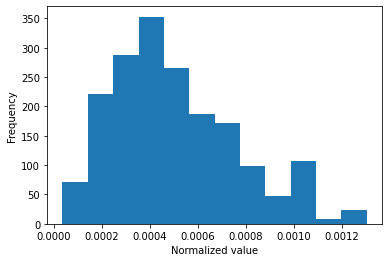

In [46]:
iqr_df = iqr_norm.copy()
for row in iqr_df.iterrows():
    if row[1]['iqr_outliers'] == True:
        iqr_df.drop(row[0], axis=0, inplace=True)

plt.hist(iqr_df['Normalized'], bins=12)
plt.xlabel('Normalized value')
plt.ylabel('Frequency')

<AxesSubplot:xlabel='Normalized', ylabel='Density'>

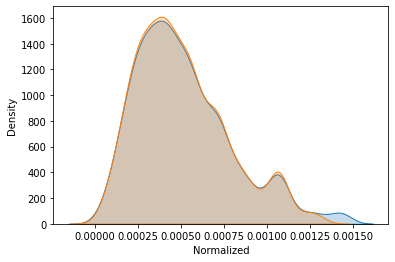

In [63]:
import seaborn as sns
ax = sns.kdeplot(z_score_df['Normalized'], shade=True)
sns.kdeplot(iqr_df['Normalized'], shade=True)

In [47]:
df_after_cols_reduction = reduced_cols_df.copy()
print(f'Before: {df_after_cols_reduction.shape}')
not_outliers_bin_cols = list(iqr_df.index)
df_after_cols_reduction = df_after_cols_reduction[cat_cols + num_cols + not_outliers_bin_cols]
print(f'After: {df_after_cols_reduction.shape}')

Before: (10070, 2617)
After: (10070, 1856)


We see that after <b>IQR</b> detection method, we removed 57 columns.  
And total number of columns is 1838 - 57 = 1781.

# Summary:
After checking both methods for detecting outliers - Z score and IQR, 
We observed that Z score results were inferior to IQR results.  
Therefore, we chose to use IQR detection method to remove outliers.

In [48]:
df_after_cols_reduction.to_csv('data/dataframes/df_after_cols_reduction3.csv')

In [49]:
df_after_cols_reduction.suceeded.sum()

1620.0